## Fit data using GLLS in SAMMY

This notebook works to shows how the sammy interface module of ATARI can be used to fit data with SAMMY

In [1]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.theory.resonance_statistics import make_res_par_avg
from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions

In [2]:
%matplotlib widget

# First, setup/generate synthetic data using SAMMY

#### Define physical values, experiment, and resonance ladder

In [3]:
ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider

Elam = 50.0
E_min_max = [np.max([Elam-20, 1.0]), Elam+20]
energy_grid = E_min_max
input_options = {'Add Noise': True,
                'Calculate Covariance': False,
                'Compression Points':[],
                'Grouping Factors':None}

# experiment_parameters = {'bw': {'val':0.8192,   'unc'   :   0},
#                          'n':  {'val':0.067166,     'unc'   :0}}
experiment_parameters = {'bw': {'val':0.1024,   'unc'   :   0},
                         'n':  {'val':0.067166,     'unc'   :0}}
# experiment_parameters = {'bw': {'val':0.0256,   'unc'   :   0},
#                          'n':  {'val':0.067166,     'unc'   :0}}

exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)

# for Gg_DOF in [10,50,100,1000,10000]:
Gg_DOF = 10

from ATARI.theory import scattering_params
shift, penetration, phi, k = scattering_params.FofE_explicit([1,500], ac, M, m, 0)
res_par_avg = make_res_par_avg(D_avg = 8.79, 
                            Gn_avg= np.mean(penetration)*2*46.4, #0.658, 
                            n_dof = 1, 
                            Gg_avg = 64.0, 
                            g_dof = Gg_DOF, 
                            print = False)


spin_groups = [ (3.0,1,0) ]
average_parameters = {'3.0':res_par_avg}

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   
resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)
# resonance_ladder = pd.DataFrame({'E':[80.0], 'Gt':[16], 'Gn':[1], 'J':[3], 'chs':[1], 'lwave':[0], 'J_ID':[1]})
# resonance_ladder = pd.DataFrame({'E':[4.0], 'Gg':[7.0], 'Gn':[4.0], 'J':[3], 'chs':[1], 'lwave':[0], 'J_ID':[1]})
resonance_ladder

,E,Gg,Gn,J,chs,lwave,J_ID
0,31.803090,54.945130,0.391340,3.0,1.0,0.0,1.0
1,32.345356,59.093993,0.058269,3.0,1.0,0.0,1.0
2,43.303183,59.745549,2.901247,3.0,1.0,0.0,1.0
3,56.064521,86.134795,2.171737,3.0,1.0,0.0,1.0
4,63.966159,67.125786,0.002140,3.0,1.0,0.0,1.0


#### Calculate theoretical cross-section using SAMMY and run Syndat experiment

This will be the first introduction to the sammy input and runtime objects. These data classes control the data given to sammy and how sammy should run.

The runtime object has the following attributes and defaults:
```
class SammyRunTimeOptions:
    path_to_SAMMY_exe: str
    model: str = 'XCT'
    reaction: str = 'total'
    experimental_corrections: str = 'all_exp'
    solve_bayes: bool = False
    one_spingroup: bool = False
    energy_window: Optional[float] = None
    sammy_runDIR: str = 'SAMMY_runDIR'
    keep_runDIR: bool = False
    shell: str = 'zsh'
    recursive: bool = False
    recursive_opt: dict = field(default_factory=lambda: {"threshold":0.01,
                                                        "iterations": 5,
                                                        "print":False}      )
```


In [24]:
sammyRTO = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    model = 'SLBW',
    reaction = 'total',
    solve_bayes = False,
    experimental_corrections = 'all_exp',
    one_spingroup = True,
    energy_window = None,
    sammy_runDIR = 'SAMMY_runDIR',
    keep_runDIR = False,
    shell = 'zsh'
    )

sammyINP = sammy_classes.SammyInputData(
    particle_pair = Ta_pair,
    resonance_ladder = resonance_ladder,
    energy_grid = exp.energy_domain)

theo_total, par_total = sammy_functions.run_sammy(sammyINP, sammyRTO)

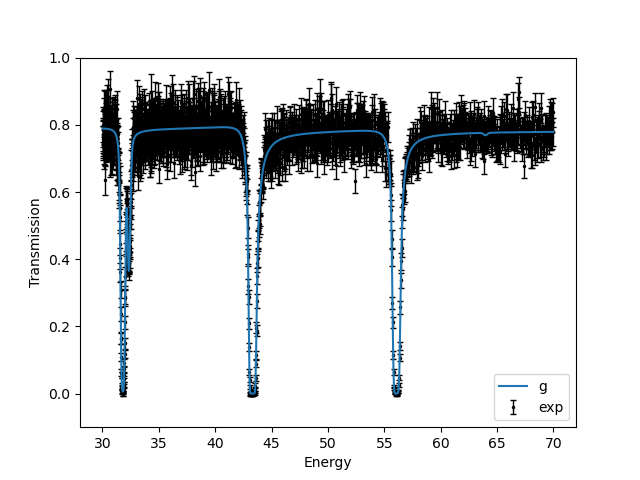

In [25]:
exp.run(theo_total)


figure()
plot(theo_total.E, theo_total.theo_trans, ms=1, label='g')
errorbar(exp.trans.E, exp.trans.exp_trans, yerr=exp.trans.exp_trans_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

# plot(exp.trans.E, exp.trans.theo_trans, color='g', lw=1, label='Sol', zorder=2)

ylim([-.1, 1])
# xscale('log')
xlabel('Energy'); ylabel('Transmission')
legend()

## This data can be fit directly by changing the solve_bayes option in the sammyRTO

In sammyINP, the resonance_ladder property gives the prior parameters and the experimental_data property supplies a dataframe of measurement data and uncertainty. Alternatively, a data covariance matrix can be supplied - though currently sammy_interface is only able to use the diagonal in the GLLS solve.

In the sammyRTO object, it is important to change the reaction to the type of data supplied in sammyINP.experimental_data['exp'].

Another useful option in sammyRTO is the recursive sammy flag. This will cause sammy GLLS to be called multiple times and each time the posterior becomes the prior. In some cases, this will give a better MLE solution to the problem as it allows the parameters to adjust more. Options for this routine can be supplied in sammyRTO.recursive_opt, these control maximum iterations, termination criteria, and printout.

<!-- | Attribute                         | Description               |
| ----------                        | -----------               |
| resonance_ladder                  | prior parameters          |
| experimental_data                 | dataframe with experimental data & unc|
| initial_parameter_uncertainty     | prior parameter uncertainty           | -->


In [26]:
sammyRTO.solve_bayes = True
sammyRTO.reaction = 'transmission'

sammyINP.experimental_data = exp.trans

pw_fit, par_fit = sammy_functions.run_sammy(sammyINP, sammyRTO)

print("prior resonance ladder:\n", resonance_ladder)
print()
print("posterior resonance ladder:\n",par_fit)

prior resonance ladder:
            E         Gg       Gn1    J  chs  lwave  J_ID
0  31.803090  54.945130  0.391340  3.0  1.0    0.0   1.0
1  32.345356  59.093993  0.058269  3.0  1.0    0.0   1.0
2  43.303183  59.745549  2.901247  3.0  1.0    0.0   1.0
3  56.064521  86.134795  2.171737  3.0  1.0    0.0   1.0
4  63.966159  67.125786  0.002140  3.0  1.0    0.0   1.0

posterior resonance ladder:
            E         Gg       Gn1  varyE  varyGg  varyGn1  J_ID
0  31.802420  63.822827  0.397487    1.0     1.0      1.0   1.0
1  32.351722  69.509533  0.057486    1.0     1.0      1.0   1.0
2  43.304563  63.209097  2.849045    1.0     1.0      1.0   1.0
3  56.064828  84.044949  2.234630    1.0     1.0      1.0   1.0
4  63.928350  63.828797  0.002863    1.0     1.0      1.0   1.0


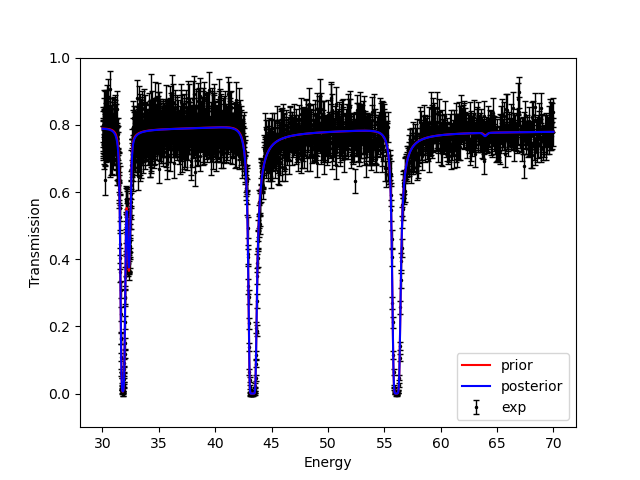

In [27]:
figure()
plot(pw_fit.E, pw_fit.theo_trans, ms=1, color='r', label='prior')
plot(pw_fit.E, pw_fit.theo_trans_bayes, ms=1, color='b', label='posterior')
errorbar(exp.trans.E, exp.trans.exp_trans, yerr=exp.trans.exp_trans_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

ylim([-.1, 1])
# xscale('log')
xlabel('Energy'); ylabel('Transmission')
legend()

## Dataclass asdict(class) command!! - might be useful for Jake

# Now, let's create some cheap capture data use it to fit as well

Syndat does not yet have the capability to generate high-fidelity, synthetic capture data. Instead, let's just generate some data with guassian noise.

In [7]:
sammyRTO.solve_bayes = False
sammyRTO.reaction = 'capture'

